In [1]:
#This loads our libraries and dependencies

import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Download data from Kaggle dataset.  If using Kaggle, you must first add the appropriate
#Dataset.  To do this: 

#1. Open a kaggle notebook.  
#2. Look in the top rght corner of the kaggle notebook screen for a button called "Add Data"
#3. If you don't see add data, click the arrow with a line in the top right corner.
#      it should look a little like this: ">|".  After clicking that, you should see "Add Data"
#4  Search for "Titanic = Machine Learning from disaster", not "Spaceship Titanic"
#5  Click the plus in a circle to the right.
#   Data Should be loaded.  Run the code below.

train_master_df=pd.read_csv('/kaggle/input/titanic/train.csv')
validation_master_df=pd.read_csv('/kaggle/input/titanic/test.csv')

In [3]:
#This sets our index to the passenger ID column
train_master_df.set_index('PassengerId', inplace=True)
validation_master_df.set_index('PassengerId', inplace=True)



In [4]:
#The survived column is the our target value (Y).  This pulls this column out
train_predict_df=train_master_df.pop("Survived")

In [5]:
#Helper function that transforms the data file by encoding and removing certain columns
#Expects a pandas_df file and returns a dataframe that has been one hot encoded, normalized and
#and unimportant data removed

def data_transform(df):
    
    #Drop columns as ether unimportant or n the case of Cabin, too many mssing values
    dropped=df.drop(labels=['Name','Ticket','Cabin'], axis=1)
    #One Hot Encodes columns and relabels columns
    transformer = make_column_transformer(
    (OneHotEncoder(), ['Pclass','Sex','Embarked']),
    remainder='passthrough')
    transformed = transformer.fit_transform(dropped)
    transformed_df = pd.DataFrame(transformed, 
    columns=transformer.get_feature_names_out(),index=df.index)
    
    
    #relabels columns of dataframe
    transformed_df.rename(columns= {'onehotencoder__Pclass_1':'1st_class', 
                                    'onehotencoder__Pclass_2':'2nd_class', 
                                    'onehotencoder__Pclass_3':'3rd_class', 
                                    'onehotencoder__Sex_female':'Female', 
                                    'onehotencoder__Sex_male':'Male',
                                    'onehotencoder__Embarked_C':'Cherbourg',
                                    'onehotencoder__Embarked_Q':'Queenstown',
                                    'onehotencoder__Embarked_S':'Southampton',
                                    'onehotencoder__Embarked_nan':'Unknown_Embarkation',
                                    'remainder__Age':'Age', 
                                    'remainder__SibSp':'SibSp', 
                                    'remainder__Parch':'Parch', 
                                    'remainder__Fare':"Fare"}, inplace=True)
    
    
    #Fills in missing value of Age and Fare as the mean (average) of column
    mean_value=transformed_df['Age'].mean()
    transformed_df['Age'].fillna(value=mean_value, inplace=True)
    
    mean_value=transformed_df['Fare'].mean()
    transformed_df['Fare'].fillna(value=mean_value, inplace=True)
    
      
    
    #normalize age and fare columns to gve values between 0 and 1.  
    normalized_age = (transformed_df['Age'] - transformed_df['Age'].min())/ (transformed_df['Age'].max() - transformed_df['Age'].min())
    transformed_df['Age']=normalized_age
    normalized_fare = (transformed_df["Fare"] - transformed_df["Fare"].min())/ (transformed_df["Fare"].max() - transformed_df["Fare"].min())
    transformed_df['Fare']=normalized_fare
    
   
    return transformed_df
    


In [6]:
#This code uses the helper function to transform training and validation data sets

train_preprocessed_df=data_transform(train_master_df)
validation_preprocessed_df=data_transform(validation_master_df)


In [7]:
#This code splits the data set into test and training data

X_train, X_test, y_train, y_test = train_test_split(train_preprocessed_df, train_predict_df, test_size=0.2, random_state=42)

In [8]:
#This code tests several different classification algorythims and ranks the best one
#Code provided by "Cole" -- https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['died', 'survived']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        final = pd.concat(dfs, ignore_index=True)
    return final

In [9]:
#This will fun all models and compare results.  In this case, we are looking for a high
#F1 score accuracy as that gives the fewest incorrect guesses.

#All but the GaussianNB appear pretty close so those other models are likely candidates

final=run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

        died       0.81      0.85      0.83       105
    survived       0.77      0.72      0.74        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

RF
              precision    recall  f1-score   support

        died       0.82      0.85      0.84       105
    survived       0.77      0.74      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

KNN
              precision    recall  f1-score   support

        died       0.81      0.87      0.83       105
    survived       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

SVM
 

In [10]:
#This code provides data for graphing results

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

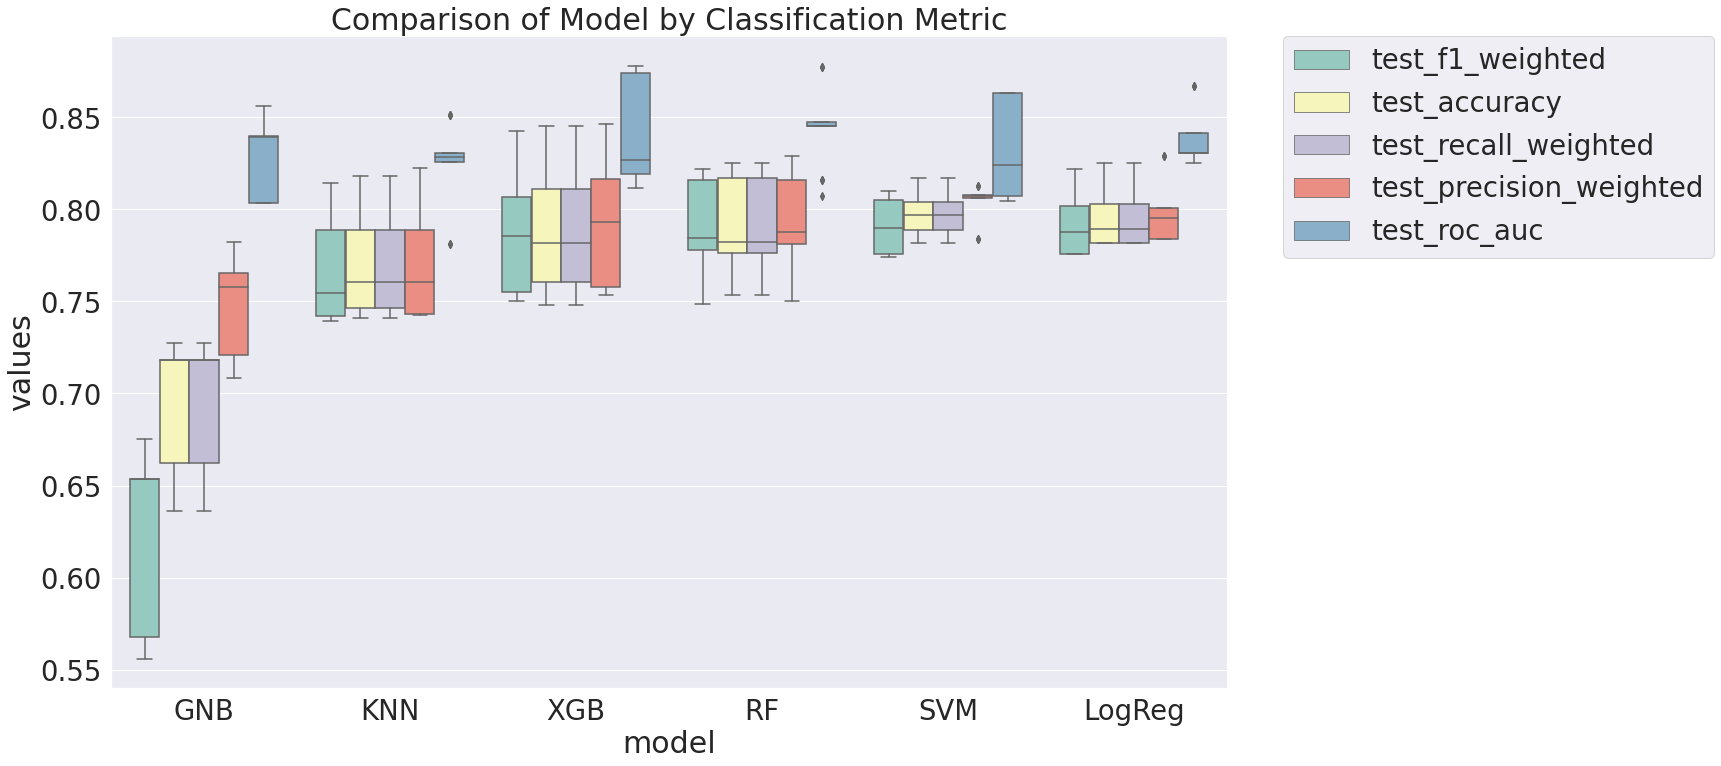

In [11]:
#This code plots the results and confirms that GNB is a poor choice for this data set.
#The other models appear possible

plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

In [12]:
#This code provides data in a table form.  We are looking for accuracy with high mean
# and low standard deviation.  Logistic Regression and SVM are the top candidates

metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_accuracy           test_f1_weighted            \
                 std      mean              std      mean   
model                                                       
GNB         0.034381  0.691336         0.047146  0.620558   
KNN         0.030297  0.774198         0.030287  0.771456   
LogReg      0.015974  0.795581         0.016260  0.792859   
RF          0.026506  0.792280         0.026458  0.791357   
SVM         0.011357  0.797654         0.013607  0.790784   
XGB         0.036473  0.790599         0.036308  0.788581   

       test_recall_weighted           test_precision_weighted            \
                        std      mean                     std      mean   
model                                                                     
GNB                0.034381  0.691336                0.027960  0.745212   
KNN                0.030297  0.774198                0.032000  0.775141   
LogReg             0.015974  0.795581                0.015221  0.798521   
RF                 0.026506  0.792280                0.027056  0.794119   
SVM                0.011357  0.797654                0.009407  0.804309   
XGB                0.036473  0.790599                0.037187  0.793577   

       test_roc_auc            
                std      mean  
model                          
GNB        0.020123  0.826205  
KNN        0.020755  0.827277  
LogReg     0.014336  0.838684  
RF         0.020520  0.843859  
SVM        0.024613  0.831196  
XGB        0.027861  0.842938

In [13]:
#I tested all models except XGB against the actual results and as expected, SVC and
#SVC was the best at predicting survival.  SVC was the best by .3% over Logistic regression


model=SVC()
clf = SVC(random_state=0).fit(X_train, y_train)


In [15]:
#If you would like to test the other models, simply remove the hash marks in 
#Front of the two lines for the model you are interested in.  You can submit
#10 entries a day to Kaggle so you can try all of them if you like

#You may need to restart by going to Run on the menu above (under the title of your notebook)
#    Then click "Restart and Clear cell outputs" and then "run all"

#model=LogisticRegression()
#clf = LogisticRegression(random_state=0).fit(X_train, y_train)

#model=KNeighborsClassifier()
#clf = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

#model=RandomForestClassifier()
#clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)

#model=XGBClassifier()
#clf = XGBClassifier(random_state=0).fit(X_train, y_train)

#model=GaussianNB()
#clf = GaussianNB().fit(X_train, y_train)

In [16]:
#This code feed validation data into our model to predict survivial

validation_preprocessed_df.insert(8,'Unknown_Embarkation',0)
predictions=clf.predict(validation_preprocessed_df)

In [17]:
#This prepares a pandas data frame and csv file for submission to Kaggle for scoring

sub = pd.DataFrame()
sub['PassengerId'] = validation_preprocessed_df.index
sub['Survived'] = predictions
#sub['Survived'] = sub['Survived']
sub.to_csv('submission.csv',index=False)

In [18]:
#Displays the passenger vs predicted survival dataframe.  If the code worked, you
#should see a two column data frame after running all cells

#If you do see the dataframe, its time to submit.  On the right of your Kaggle notebook
#click the down arrow next to "Submit to Competition" and then click submit.
#After naming and running the notebook, you should see a Latest score of 0.77511

#If you don't see submit to competition, click the |< button in the top right hand corner 
#of the Kaggle notebook(next to the "Save Version" button)

sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
